<a href="https://colab.research.google.com/github/kiyong21c/kaggle/blob/main/20220615_porto-seguro-safe-driver-prediction-modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 안전운전자 예측
 - 실제 보험사에서 제공한 고객 데이터 활용하여 운전자가 보험을 청구할 확률 예측
 - 문제유형 : 이진분류
 - 평가지표 : 정규화된 지니계수
 - 사용모델 : LightGBM, XGBoost의 앙상블

## 베이스라인 모델
 - LightGBM : 마이크로소프트 개발, XGBoost와 함께 캐글에서 가장 많이 사용
 - **파이썬 래퍼 LightGBM** / 사이킷럿 래퍼 LightGBM 두가지가 있음

In [41]:
import pandas as pd

data_path = '/content/drive/MyDrive/Colab Notebooks/kaggle/input/porto-seguro-safe-driver-prediction/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

### 피처 엔지니어링

#### 데이터 합치기
 - 훈련 데이터와 테스트 데이터를 합쳐서 한번에 인코딩을 적용하기 위함
 - 타깃값에는 인코딩 적용하지 않으므로 제거

In [42]:
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop('target', axis=1) # 타깃값 제거

In [43]:
all_features = all_data.columns
all_features

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

In [44]:
hasattr(all_features, "__iter__")

True

#### 명목형 피처 원-핫 인코딩
 - 명목형 데이터는 고윳값별 순서가 따로 없다 → 원-핫 인코딩
 - 피처 이름에 'cat'이 포함된 피처가 명목형 피처

In [45]:
from sklearn.preprocessing import OneHotEncoder

# List Comprehension
cat_features = [feature for feature in all_features if 'cat' in feature]

onehot_encoder = OneHotEncoder() # 원-핫 인코더 객체 생성

encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features]) # 인코딩

encoded_cat_matrix

<1488028x184 sparse matrix of type '<class 'numpy.float64'>'
	with 20832392 stored elements in Compressed Sparse Row format>

 - 명목형 피처 14열 → 인코딩 후 184열
 - CSR(Compressed Sparse Row format) 형식

In [46]:
col_sum = 0
for i in range(len(cat_features)):
    col_sum += all_data[cat_features[i]].nunique()

col_sum

184

 - 명목형 피처 각각의 고윳값 개수만큼 원-핫 인코딩시 열이 생김

#### 필요 없는 피처 제거

In [47]:
# 추가로 제거할 피처
drop_features = ['ps_ind_14','ps_ind_10_bin','ps_ind_11_bin',
                 'ps_ind_12_bin','ps_ind_13_bin','ps_car_14']
# 1) 명목형 피처, 2) calc 분류의 피처, 3)추가로 제거할 피처  1),2),3) 세가지를 제외한 피처만 남긴다
remaining_features = [feature for feature in all_features
                      if ('cat' not in feature and
                          'calc' not in feature and
                          feature not in drop_features)]

 - 1.encoded_cat_matrix : 원-핫 인코딩된 CSR 형식
 - 2.all_data(remaining_features) : DataFrame
 - 두 데이터를 합침

In [48]:
from scipy import sparse

all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data[remaining_features]),
                               encoded_cat_matrix],
                              format='csr') # 기본 형식은 COO

In [49]:
all_data_sprs

<1488028x201 sparse matrix of type '<class 'numpy.float64'>'
	with 37628974 stored elements in Compressed Sparse Row format>

#### 데이터 나누기

In [50]:
num_train = len(train)

X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values # Series → array

### 평가지표 계산 함수 작성
 - 본 경진대회 평가지표는 정규화된 지니계수
 - 파이썬/사이킷런에서 제공X, 직접 만들어야 함

#### 정규화 지니계수
 - 정규화 : 값의 범위를 0~1 사이로 조정한다는 뜻
 - 정규화 지니계수는 값이 0에 가까울수록 성능이 나쁘고, 1에 가까울수록 성능이 좋다
  > 정규화 지니계수 = 예측 값에 대한 지니계수 / 예측이 완벽할 때의 지니계수

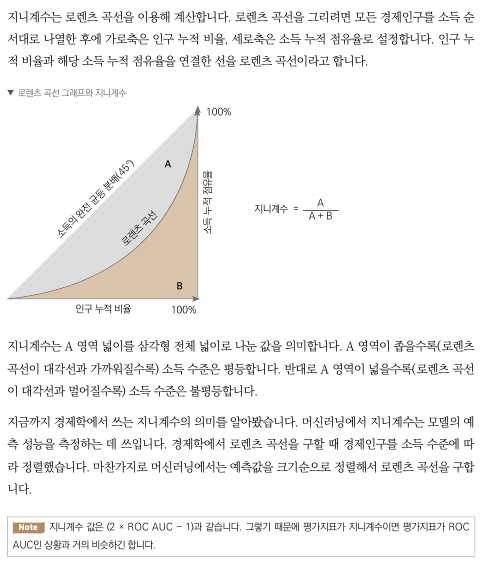

In [61]:
# 실제 타깃값(y_true)와 예측 확률값(y_pred) 입력받아 정규화 지니계수 반환
import numpy as np

def eval_gini(y_true, y_pred):
    assert y_true.shape == y_pred.shape # assert : True가 아니면 오류 발생

    n_samples = y_true.shape[0] # 데이터 개수
    L_mid = np.linspace(1/n_samples, 1, n_samples) # 대각선 값

    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred.argsort() : y_pred배열 오름차순 인덱스값 배열
    # 즉, y_pred 크기순으로 y_true 정렬
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
    G_pred = np.sum(L_mid - L_pred) # 예측값에 대한 지니계수

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true 크기순으로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true) # 예측이 완벽할 때 지니계수

    # 정규화된 지니계수
    return G_pred / G_true

 - 보통 평가지표 계산 함수는 다른 캐글러가 만들엉 공유해준다

In [52]:
import numpy as np

np.linspace(1/10, 1, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [53]:
a = np.array([[1, 2, 3], [4, 5, 6]])
np.cumsum(a) # 누적합 배열(행, 열 구분 없어짐)

array([ 1,  3,  6, 10, 15, 21])

In [54]:
# LightGBM용 gini() 함수
def gini(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True
    # 평가지표이름, 평가점수, 평가점수가 높을수록 좋은지여부?
    # 이후 lightGBM의 훈련시 feval 파라미터로 들어가는 함수로써 3가지 값을 요구함

### 모델 훈련 및 성능 검증

#### OOF 예측방식(Out of Fold prediction)
 - 지금까지는 테스트 데이터 전체를 사용해 결과를 예측했으나,
 - K폴드 교차 검증을 수행하면서 각 폴드마다 테스트 데이터로 예측하여 평균을 내는 방식
  > 각 폴드 마다 **[검증 데이터 예측확률]**과 **[테스트 데이터 예측확률]**을 구함

  > 각 폴드 마다의 테스트 데이터 예측확률의 평균을 구함 = **최종 예측 확률**

  > 검증 데이터 예측확률과 훈련 데이터의 타깃값을 이용해 훈련된 **모델의 성능 평가**

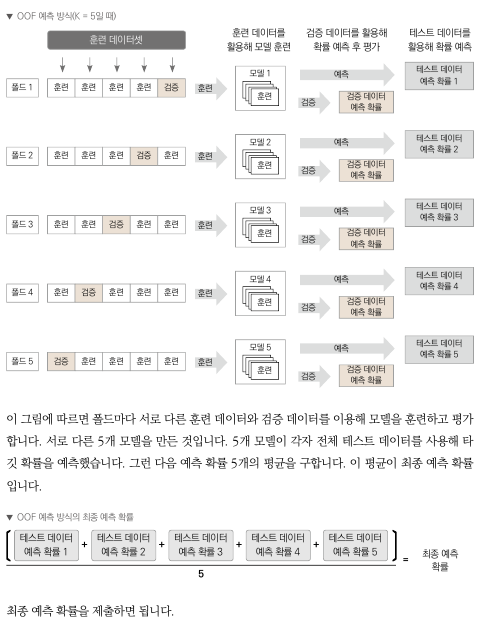

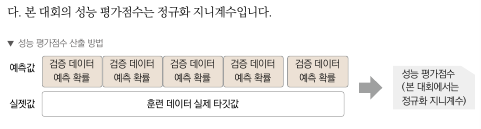

 - 기대효과
  > **1.과대적합 방지** : 훈련시 접하지 못한 데이터(검증데이터)로 성능을 평가

  > **2.앙상블 효과** : 단일 모델로 한번만 예측하는것이 아니라, K개 모델로 K번 예측해 평균냄

#### OOF 방식으로 LightGBM 훈련
 - 베이스라인 모델로 LightGBM 사용
 - 층화 K 폴드 교차 검증 : 타깃값이 균등하게 배치 되게 폴드를 나누는 방식
 - 본 경진대회의 타깃값이 불균형 하므로

In [55]:
from sklearn.model_selection import StratifiedKFold

# 층화 K 폴드 교차 검증기
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1991)
# 시계열 데이터는 순서가 중요해서 섞으면 안된다.

In [56]:
# LightGBM의 하이퍼파라미터 설정
params = {'objective':'binary', # 이진분류 문제
          'learning_rate':0.01, # 학습률
          'force_row_wise':True, # 경고 문구를 없애기 위한 파라미터(신경X)
          'random_state':0}

In [63]:
# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열 초기화
oof_val_preds = np.zeros(X.shape[0])
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열 초기화
oof_test_preds = np.zeros(X_test.shape[0])

 - oof_val_preds가 검증데이터 크기가 아닌, 왜 훈련 데이터 크기의 배열 인가?
  > K 폴드로 나눠도 훈련 데이터 전체가 결국엔 한번씩 검증 데이터로 활용되므로

In [64]:
import lightgbm as lgb

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)): # 훈련데이터 및 타깃 데이터를 folds에 따라 K등분하고, 그 인덱스를 반환, 층화 교차 검증이므로 y값도 주어져야 함
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)

    # 훈련용 데이터, 검증용 데이터 설정
    X_train, y_train = X[train_idx], y[train_idx] # 훈련용 데이터
    X_valid, y_valid = X[valid_idx], y[valid_idx] # 검증용 데이터

    # LightGBM 전용 데이터셋 생성
    dtrain = lgb.Dataset(X_train, y_train) # lightGBM 전용 훈련 데이터셋
    dvalid = lgb.Dataset(X_valid, y_valid) # lightGBM 전용 검증 데이터셋

    # LightGBM 모델 훈련(LGBM 전용 훈련데이터셋 + LGBM 전용 검증데이터셋)
    lgb_model = lgb.train(params=params,            # 훈련용 하이퍼파라미터
                          train_set=dtrain,         # 훈련 데이터셋
                          num_boost_round=1000,     # 부스팅 반복 횟수
                          valid_sets=dvalid,        # 검증 데이터셋(성능 평가용)
                          feval=gini,               # 검증용 평가지표(3가지 값을 반환하는 함수인 gini)
                          early_stopping_rounds=100,# 조기종료 조건
                          verbose_eval=100)         # 100
    
    # LightGBM 모델 활용해 테스트 데이터 타깃값의 평균 예측 : OOF
    oof_test_preds += lgb_model.predict(X_test)/folds.n_splits # lgb.Dataset()이 아닌 원본 데이터사용
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid) # lgb.Dataset()이 아닌 원본 데이터사용

    # 검증 데이터 예측 확률에 대한 정규화 지니계수
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'폴드 {idx+1} 지니계수: {gini_score}\n')

######################################## 폴드 1 / 폴드 5 ########################################
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.15336	valid_0's gini: 0.261801
[200]	valid_0's binary_logloss: 0.152428	valid_0's gini: 0.275964
[300]	valid_0's binary_logloss: 0.152018	valid_0's gini: 0.282624
[400]	valid_0's binary_logloss: 0.151798	valid_0's gini: 0.286985
[500]	valid_0's binary_logloss: 0.151716	valid_0's gini: 0.288374
[600]	valid_0's binary_logloss: 0.151677	valid_0's gini: 0.288793
[700]	valid_0's binary_logloss: 0.151671	valid_0's gini: 0.288778
Early stopping, best iteration is:
[646]	valid_0's binary_logloss: 0.151673	valid_0's gini: 0.288887
폴드 1 지니계수: 0.2888871820172969

######################################## 폴드 2 / 폴드 5 ########################################
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.153506	valid_0's gini: 0.249477
[200]	valid_0's binary_logl

 - 폴드가 5개라서 로그 묶음도 5개
 - 모델 훈련시 verbose_eval=100 : 100번째 이터레이션 마다 성능 평가점수를 출력
 - 성능 평가점수는 두가지(logloss, gini), 검증용 데이터로 계산한 값
 - logloss : 이진분류할 때 LightGBM의 기본평가 지표
 - gini : 모델 훈련 시 feval 파라미터에 전달한 gini() 함수의 계산값(조기종료 적용)
 - 이터레이션 반복할수록 지니계수 커짐 : 모델 성능 향상
 - num_boost_rounds=1000 : 최대반복횟수
 - 600번 이터레이션에서 조기종료 됨
 - early_stopping_rounds=100 : 100번 연속으로 지니계수가 최댓값을 갱신하지 못하면 훈련 종료
 - 종료 시까지 정규화 지니계수가 가장 높았던 [594]번째 이터레이션, 이때의 지니계수 0.288332

In [65]:
# 검증 데이터로 예측한 확률을 실제 타깃값과 비교해 지니계수 출력
print('OOF 검증 데이터 지니계수:', eval_gini(y, oof_val_preds))

OOF 검증 데이터 지니계수: 0.2804880266267947


### 예측 및 결과제출
 - 최종 예측 확률은 oof_test_preds에 담겨있음
 - OOF 예측방식으로 총 5개 폴드로 교차 검증한 확률값들의 평균

In [66]:
submission['target'] = oof_test_preds
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/input/porto-seguro-safe-driver-prediction/submission.csv')